In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential

In [2]:
df_1=pd.read_csv('dc_part.csv')
df_2=pd.read_csv('chenqin5%.csv')

df_4=pd.read_csv('yunDataN.csv')
print(df_1.shape,df_2.shape,df_4.shape)

(124293, 147) (124293, 92) (124293, 74)


# Mergeing the 4 parts of the datasets with the zero-rate less than 95%

In [3]:
data_parts=[df_1,df_2,df_4]
useful=[] # the column names for each parts that have less than 95% zeros
for ele in data_parts:
  useful_sub=[]
  for col in ele.columns:
    if ele[col].isin([0]).sum()/ele.shape[0]<0.95:
      useful_sub.append(col)
  useful.append(useful_sub)
useful[2]=useful[2][1:]  # drop unuseful column_name in the 4th part

In [4]:
df_1=df_1.loc[:,useful[0]]
df_2=df_2.loc[:,useful[1]]
df_4=df_4.loc[:,useful[2]]

In [5]:
result = pd.concat([df_1,df_2,df_4], axis=1, sort=False) # combine the dateset

In [6]:
result.head()

,_key_client_id,_key_occurreddate_month,Total_incident_count,response_variable,incident_subcatgry_unknown_piv,prgcontct_other_organisation_piv,prgcontct_lwb_worker_piv,prgcontct_both_client_and_carer_piv,prgcontct_department_piv,prgcontct_family_piv,prgcontct_carer_piv,prgcontct_client_piv,prgcontct_meeting_group_of_people_piv_sum_n_days,prgcontct_other_organisation_piv_sum_n_days,prgcontct_educational_institution_piv_sum_n_days,prgcontct_lwb_worker_piv_sum_n_days,prgcontct_both_client_and_carer_piv_sum_n_days,prgcontct_health_professional_piv_sum_n_days,prgcontct_department_piv_sum_n_days,prgcontct_other_stakeholder_piv_sum_n_days,prgcontct_family_piv_sum_n_days,prgcontct_carer_piv_sum_n_days,prgcontct_client_piv_sum_n_days,prgcontct_meeting_group_of_people_piv_days_since,prgcontct_other_organisation_piv_days_since,prgcontct_meeting_lwb_internal_only_piv_days_since,prgcontct_educational_institution_piv_days_since,prgcontct_employer_piv_days_since,prgcontct_lwb_worker_piv_days_since,prgcontct_police_piv_days_since,prgcontct_both_client_and_carer_piv_days_since,prgcontct_health_professional_piv_days_since,prgcontct_department_piv_days_since,prgcontct_other_stakeholder_piv_days_since,prgcontct_family_piv_days_since,prgcontct_carer_piv_days_since,prgcontct_client_piv_days_since,progsubjcat_information_provided_piv,progsubjcat_case_discussion_planning_piv,progsubjcat_i_sight_client_incident_system_generated_piv,...,rowtype_reference_piv_avg_n_days,rowtype_client_address_addition_piv_days_since,rowtype_rp_end_piv_days_since,rowtype_rp_start_piv_days_since,rowtype_progress_note_piv_days_since,rowtype_diagnosis_piv_days_since,rowtype_medictn_start_piv_days_since,rowtype_client_plan_start_piv_days_since,rowtype_client_plan_end_piv_days_since,rowtype_keyworker_change_piv_days_since,rowtype_reference_piv_days_since,rowtype_medictn_end_piv_days_since,rowtype_plcment_end_piv_days_since,rowtype_incident_piv_days_since,rowtype_plcment_start_piv_days_since,rowtype_program_primary_service_type_start_piv_days_since,rowtype_client_alert_start_piv_days_since,rowtype_client_address_addition_piv_lag01,rowtype_rp_end_piv_lag01,rowtype_rp_start_piv_lag01,rowtype_progress_note_piv_lag01,rowtype_diagnosis_piv_lag01,rowtype_medictn_start_piv_lag01,rowtype_client_plan_start_piv_lag01,rowtype_client_plan_end_piv_lag01,rowtype_keyworker_change_piv_lag01,rowtype_reference_piv_lag01,rowtype_medictn_end_piv_lag01,rowtype_plcment_end_piv_lag01,rowtype_incident_piv_lag01,rowtype_plcment_start_piv_lag01,rowtype_program_primary_service_type_start_piv_lag01,rowtype_client_alert_start_piv_lag01,status_placement,status_client_plan,status_rp_mechanical_restraint,status_rp_restricted_access,status_rp_chemical_restraint,status_rp_other,Incident
0,0000D172-EA88-432F-8235-9FAA00D29072,2019-04-01T00:00:00.0,0,0,29,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3650,3650,3650,3650,3650,3650,3650,3650,3650,3650,3650,2868,3650,3650,0,1,0,...,1,603,355,376,890,515,492,761,555,345,2,425,469,703,527,577,488,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,1,2,2,2,0
1,0000D172-EA88-432F-8235-9FAA00D29072,2019-05-01T00:00:00.0,0,0,31,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3650,3650,3650,3650,3650,3650,3650,3650,3650,3650,3650,22,3650,3650,0,0,0,...,1,603,355,376,21,515,492,761,555,345,0,425,469,703,527,577,488,1,1,1,2,1,1,1,1,1,38,1,1,1,1,1,1,2,2,1,2,2,2,0
2,0000D172-EA88-432F-8235-9FAA00D29072,2019-06-01T00:00:00.0,0,0,31,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3650,3650,3650,3650,3650,3650,3650,3650,3650,3650,3650,52,3650,3650,0,0,0,...,1,559,355,376,51,515,492,761,555,345,0,425,469,703,527,577,488,1,1,1,1,1,1,1,1,1,46,1,1,1,1,1,1,2,2,1,2,2,2,0
3,0000D172-EA88-432F-8235-9FAA00D29072,2019-07-01T00:00:00.0,0,0,32,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,3650,3650,3650,3650,3650,3650,3650,3650,3650,3650,3650,83,3650,483,0,1,0,...,1,21,355,376,20,515,492,761,555,345,0,425,469,703,527,577,488,3,1,1,1,1,1,1,1,1,40,1,1,1,1,1,1,2,2,1

### Parse 'Dates' and indexs it

In [7]:
result.to_csv('Dataconcate.csv')

In [8]:
Dataset=pd.read_csv('Dataconcate.csv',parse_dates=['_key_occurreddate_month'],index_col=['_key_client_id','_key_occurreddate_month'])

In [9]:
Dataset.drop(['Unnamed: 0','response_variable'],axis=1).head()

Total_incident_count  ...  Incident
_key_client_id                       _key_occurreddate_month                        ...          
0000D172-EA88-432F-8235-9FAA00D29072 2019-04-01                                  0  ...         0
                                     2019-05-01                                  0  ...         0
                                     2019-06-01                                  0  ...         0
                                     2019-07-01                                  0  ...         0
                                     2019-08-01                                  0  ...         0

[5 rows x 150 columns]

In [10]:
client_id=list(Dataset.index.get_level_values(0)) # the value of '_key_client_id' indexe

### Remove the Useless records

In [11]:
from collections import Counter
occurrences = Counter(client_id)

In [12]:
used_id=[]
usedless_id=[]
for key, value in occurrences.items():
  if value==12:  # number can be changed
    used_id.append(key)
  else:
    usedless_id.append(key)

In [13]:
print(f'Useful client:  {len(used_id):d}\nUseless client: {len(usedless_id):d}')

Useful client:  7380
Useless client: 7007


In [14]:
# remove the rows that the record of client is less than 12 month 
Dataset=Dataset.drop(usedless_id,level=0) 
Dataset.shape

(88560, 152)

In [15]:
Dataset.drop(['Unnamed: 0','response_variable'],axis=1,inplace=True)

## Perparing Dateset for Modelling

### Spliting to Train and Test Set

In [16]:
split=int(0.9*len(used_id))
train_index=used_id[:split] # the clients who will in trainset
test_index=used_id[split:] # the clients who will in testset

# Train dataset
train=Dataset.loc[train_index]
train_x = train.drop('Incident',axis=1)
train_y = train.Incident

# Test Dataset
test=Dataset.loc[test_index]
test_x = test.drop('Incident',axis=1)
test_y = test.Incident

print(train.shape,test.shape)

(79704, 150) (8856, 150)


### Normalize the Data

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

train_x = scaler.fit_transform(train_x)

test_x = scaler.transform(test_x)

###Serializing the Dataset

In [18]:
# 4D output
import numpy as np

def create_dataset(X, y, time_steps, window, number):
  xs, ys,channel = [],[],0
  while channel < number: # Ensure all client data have changed to time series type
    xs_sub, ys_sub =[],[]
    for i in range(window - time_steps):
      shifft= window * channel
      v = X[i+shifft:(i + shifft + time_steps)]
      xs_sub.append(v)
      ys_sub.append(y[i + shifft + time_steps])

    channel+=1
    xs.append(xs_sub)
    ys.append(ys_sub)

  return np.array(xs),np.array(ys)

In [19]:
TIME_STEPS = 4
WINDOW = 12 # control client change
NUM_TRAIN = len(train_index)
NUM_TEST = len(test_index)

X_train, y_train = create_dataset(train_x,train_y, TIME_STEPS, WINDOW, NUM_TRAIN)
X_test, y_test = create_dataset(test_x, test_y, TIME_STEPS, WINDOW,NUM_TEST)

In [20]:
# [n_samples, (n_sub_sequence),TIME_STEPS, n_features]
print(X_train.shape, y_train.shape)

(6642, 8, 4, 149) (6642, 8)


## LSTM AutoEncoder

In [21]:
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
''' 4D input [n_samples, n_sub_sequence,TIME_STEPS, n_features]'''
def ConvLSMT_autoencoder(X):
  model = Sequential()
  model.add(layers.TimeDistributed(layers.Conv1D(filters=16, kernel_size=1, activation='relu'), input_shape=(None, X.shape[2], X.shape[3])))
  model.add(layers.TimeDistributed(layers.MaxPooling1D(pool_size=2)))
  model.add(layers.TimeDistributed(layers.Flatten()))
  model.add(layers.LSTM(32, activation='relu'))
  model.add(layers.RepeatVector(X.shape[2]))
  model.add(layers.LSTM(4, activation='relu', return_sequences=True))
  model.add(layers.Flatten())
  model.add(layers.Dense(8,activation='sigmoid'))
  return model

In [22]:
model = ConvLSMT_autoencoder(X_train)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 4, 16)       2400      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 2, 16)       0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 32)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 4, 32)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 4)              592       
_________________________________________________________________
flatten_1 (Flatten)          (None, 16)                0

In [23]:
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [45]:
history = model.fit(
    X_train,y_train,
    epochs = 180,
    batch_size = 48,
    validation_split = 0.1,
    shuffle = False)

Epoch 1/180
125/125 [==============================] - 1s 10ms/step - loss: 0.0936 - accuracy: 0.2316 - val_loss: 0.1263 - val_accuracy: 0.2241
Epoch 2/180
125/125 [==============================] - 1s 10ms/step - loss: 0.0934 - accuracy: 0.2324 - val_loss: 0.1263 - val_accuracy: 0.2226
Epoch 3/180
125/125 [==============================] - 1s 10ms/step - loss: 0.0932 - accuracy: 0.2327 - val_loss: 0.1260 - val_accuracy: 0.2226
Epoch 4/180
125/125 [==============================] - 1s 10ms/step - loss: 0.0930 - accuracy: 0.2327 - val_loss: 0.1259 - val_accuracy: 0.2256
Epoch 5/180
125/125 [==============================] - 1s 10ms/step - loss: 0.0928 - accuracy: 0.2326 - val_loss: 0.1258 - val_accuracy: 0.2256
Epoch 6/180
125/125 [==============================] - 1s 10ms/step - loss: 0.0926 - accuracy: 0.2326 - val_loss: 0.1256 - val_accuracy: 0.2271
Epoch 7/180
125/125 [==============================] - 1s 10ms/step - loss: 0.0924 - accuracy: 0.2322 - val_loss: 0.1254 - val_accuracy:

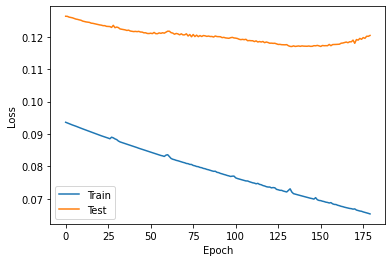

In [46]:
import matplotlib.pyplot as plt
plt.plot(history.epoch, history.history['loss'], label='Train')
plt.plot(history.epoch, history.history['val_loss'], label='Test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Find the threshold for dividing positive samples and neigative samples

In [47]:
predict = model.predict(X_test)
predict.shape

(738, 8)

In [48]:
predict[1]

array([3.1989830e-10, 1.6766459e-13, 8.4649336e-09, 2.1412727e-11,
       2.0865721e-07, 2.8799994e-09, 8.4992163e-05, 1.5417218e-02],
      dtype=float32)

In [49]:
predict[0]

array([4.14821733e-10, 1.02609056e-13, 2.69688456e-07, 2.20395574e-13,
       1.74146852e-09, 8.92523833e-11, 8.73381505e-05, 1.79708302e-02],
      dtype=float32)

In [50]:
month=['May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
Client = used_id[-y_test.shape[0]:]

preidct_df = pd.DataFrame(predict,columns=month,index=Client,)
True_df=pd.DataFrame(y_test,columns=month,index=Client)

In [51]:
preidct_df.describe()

,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
count,7.380000e+02,7.380000e+02,7.380000e+02,7.380000e+02,7.380000e+02,7.380000e+02,7.380000e+02,738.000000
mean,8.273429e-02,9.621669e-02,8.806697e-02,7.224809e-02,7.243405e-02,7.037926e-02,6.710727e-02,0.071300
std,2.514661e-01,2.690479e-01,2.623751e-01,2.320187e-01,2.265299e-01,2.271602e-01,2.013798e-01,0.138529
min,1.081698e-18,8.389462e-22,1.258967e-18,1.200217e-16,1.007135e-13,3.383993e-13,1.501225e-09,0.000027
25%,1.103760e-09,6.915099e-13,8.981293e-09,6.077340e-11,8.423221e-08,3.535943e-09,8.659382e-05,0.013800
50%,1.582896e-08,4.048705e-11,2.149223e-07,2.920441e-09,1.691938e-06,1.910424e-07,7.193685e-04,0.027059
75%,4.814714e-04,9.238163e-05,9.614237e-05,7.047597e-05,1.372777e-03,1.331747e-03,1.193739e-02,0.062594
max,9.999913e-01,9.999990e-01,9.999996e-01,1.000000e+00,9.999946e-01,1.000000e+00,9.993033e-01,0.985566


In [52]:
preidct_df.head()

,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
DB10AF3E-0F92-E011-A5C6-B6A03279A8B3,4.148217e-10,1.026091e-13,2.696885e-07,2.203956e-13,1.741469e-09,8.925238e-11,0.000087,0.017971
DB1CE471-B20F-434C-B4D4-9F6D00D10976,3.198983e-10,1.676646e-13,8.464934e-09,2.141273e-11,2.086572e-07,2.879999e-09,0.000085,0.015417
F771E77B-341D-4672-B6AD-A43500AB411B,1.674671e-09,3.007650e-04,9.955635e-01,7.533531e-01,3.662172e-02,2.956092e-04,0.003878,0.218367
F77DFB42-B83B-47FD-BBA9-A88D00E983C1,5.298463e-09,4.332762e-12,4.071551e-08,7.584374e-05,9.657054e-01,2.975866e-01,0.030134,0.150539
E9D0885E-57E7-4EE6-A384-A61200D8ABF1,3.024758e-05,4.621201e-08,5.732369e-06,1.927392e-08,1.780898e-06,2.972266e-06,0.004229,0.073372


In [53]:
True_df.head()

,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
DB10AF3E-0F92-E011-A5C6-B6A03279A8B3,0,0,0,0,0,0,0,0
DB1CE471-B20F-434C-B4D4-9F6D00D10976,0,0,0,0,0,0,0,0
F771E77B-341D-4672-B6AD-A43500AB411B,0,0,1,1,0,0,0,0
F77DFB42-B83B-47FD-BBA9-A88D00E983C1,0,0,0,0,1,1,0,0
E9D0885E-57E7-4EE6-A384-A61200D8ABF1,0,0,0,0,0,0,0,0


## Build a dataframe which contains two columns: Predited_value and True_Value for modelling

In [54]:
# Combine dataframe to a single column
len=preidct_df.shape[0]
name_all=[] # predicted values
value_all=[] # months
true_all=[]
for elem in month:
  value_all+=(list(preidct_df[str(elem)]))
  true_all += (list(True_df[str(elem)]))
  name_all += [elem]*len

In [55]:
# build the client column
client=[]
for i in range(preidct_df.shape[1]):
  client+=Client

In [56]:
# Build the datafame
dataset=pd.DataFrame(zip(value_all,name_all,true_all),columns=['Predict','Month','Label'])
dataset['Client_id']=client
dataset.set_index(['Month','Client_id'],inplace=True)
dataset.head()

Predict  Label
Month Client_id                                                
May   DB10AF3E-0F92-E011-A5C6-B6A03279A8B3  4.148217e-10      0
      DB1CE471-B20F-434C-B4D4-9F6D00D10976  3.198983e-10      0
      F771E77B-341D-4672-B6AD-A43500AB411B  1.674671e-09      0
      F77DFB42-B83B-47FD-BBA9-A88D00E983C1  5.298463e-09      0
      E9D0885E-57E7-4EE6-A384-A61200D8ABF1  3.024758e-05      0
...                                                  ...    ...
Dec   FF6FAE85-F726-41F9-9AB0-9F6700A5F60D  8.625297e-01      1
      FF904024-61CC-44DF-85A4-A2DF00AC73ED  4.668292e-02      0
      FFC97BEE-F44B-4BF5-98DA-A82600AB81CA  9.492785e-03      0
      FFD43505-079D-465A-BA25-A4AB00EA8F27  1.218587e-02      0
      FFFC53E9-CB2E-4F30-A3B7-AA1400F5BEF6  1.798528e-02      0

[5904 rows x 2 columns]

## Spliting the predicted value to Test and Train sets for finding the threshold

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
rate=0.2
train, test = train_test_split(dataset, test_size=rate, random_state=5)

In [95]:
'''splitting the dataset to X and Y'''
# X
train_xth = train.Predict
test_xth = test.Predict

# Y
train_yth = train.Label
test_yth = test.Label

print('The sizes for training dataset and test dataset:\n',train_xth.shape,test_xth.shape)

The sizes for training dataset and test dataset:
 (4723,) (1181,)


### Plotting the Loss

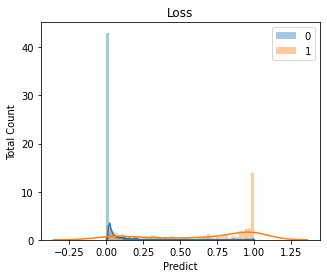

In [60]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5, 4))
for i in [0,1]:
  sns.distplot(train_xth.loc[train.Label==i], bins=50,kde=True)
ax.set_ylabel('Total Count')
ax.set_title('Loss')
ax.legend('01')

### Finding the best threshold

In [61]:
# from the above plot we can choose the threshold to be 0.2 or greater
'''Generate the list for thresholds'''
threshold = []
num = 4000
start=0.2
for i in range(num):
  val= start+0.0001*i
  threshold.append(val)


In [62]:
# generate the list of f1_scores 
from sklearn.metrics import f1_score
f1_scores=[]
for thres in threshold:
  Predited_label = []
  for elem in test_xth:
    if elem < thres:
      Predited_label.append(0)
    else:
      Predited_label.append(1)
  f1s=f1_score(test_yth, Predited_label, zero_division=0)
  f1_scores.append(f1s)

In [63]:
# get the corrodinate of the largest f1_score
y=max(f1_scores)
max_index = f1_scores.index(max(f1_scores))
x=threshold[max_index]

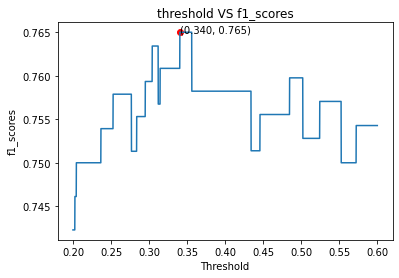

In [64]:
plt.plot(threshold,f1_scores)
plt.title('threshold VS f1_scores')
plt.scatter(x, y, c='red')
plt.xlabel('Threshold')
plt.ylabel('f1_scores')
plt.text(x, y, '({:5.3f}, {:5.3f})'.format(x, y))
plt.show()

In [93]:
print(f'The best f1_scores is{y: 5.4f} for threshold is{x: 5.4f}.')

The best f1_scores is 0.7650 for threshold is 0.3404.


### Show the performance of the model

In [127]:
# label the prediction with the choosen threshold
predited_label=[]
incident_index=[]# incident list
for elem in test_xth:
  if elem < x:
    predited_label.append(0)
  else:
    predited_label.append(1)
    indx = test_xth.loc[(test_xth.loc[:]==elem),:].index.values.tolist()
    incident_index+=indx

In [103]:
test_xth.loc[:]==0.005

Month  Client_id                           
Dec    E3B43A14-5FE0-42CD-8616-9F6B00B96188    False
       EA2D6643-42D8-4D56-B436-A88100CD66A0    False
Jul    F9450494-2C4B-41C8-B0CA-A708011E543E    False
Dec    F618507A-1E7C-4CEB-B0AD-40DEC5C60791    False
Oct    DC14B2EA-94B3-4EFC-8387-A3E100D6644C    False
                                               ...  
Dec    F3AEC4AF-0122-4F2B-97D0-A84700E49B5B    False
May    F3CAD5F0-48A0-4C93-9651-AA1600FD9209    False
Nov    F408760B-C8A4-4EFD-B395-51F5B96D15E3    False
Jun    EA2DA875-A899-4EDD-870D-A3D201017656    False
Nov    F8052799-003F-4FB8-A79C-A86500FAFB90    False
Name: Predict, Length: 1181, dtype: bool

In [78]:
from sklearn.metrics import classification_report

report = classification_report(test_yth, predited_label,labels=[1,0])
print(report)

              precision    recall  f1-score   support

           1       0.80      0.73      0.77        96
           0       0.98      0.98      0.98      1085

    accuracy                           0.96      1181
   macro avg       0.89      0.86      0.87      1181
weighted avg       0.96      0.96      0.96      1181



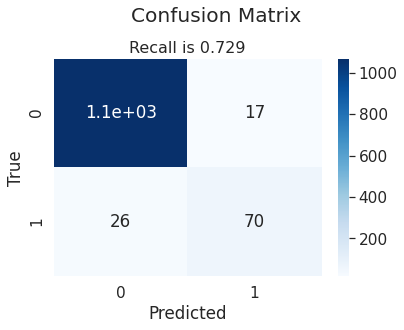

In [92]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

cm = confusion_matrix(test_yth, predited_label)
recal = cm[1][1]/sum(cm[1])

sns.heatmap(cm, annot=True,cmap='Blues')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title(f'Recall is {recal:0.3f}',y=1.05, fontsize=16)
plt.suptitle('Confusion Matrix',y=1.06)

plt.show()

The best result is when epcho is 180, threshold is 0.3404, and f1_score is 0.765  and recall is 0.73. (without drop out)

## The clients who should pay attention to.

In [132]:
print('The risky clients in each month:')
df=pd.DataFrame(incident_index,columns=['Month', 'Client_id'])
df.sort_values(by=['Month'])

The risky clients in each month:


,Month,Client_id
44,Aug,FC2AD89C-C556-4330-8D12-A5B80124C3AC
5,Aug,FE1B1799-A662-4DA4-B04E-A92201051ECE
57,Aug,F850ACDB-093F-45B1-A1B1-A097009F6F79
22,Aug,FC5255AA-72B3-4EFF-9AF1-A38000F3DC56
81,Aug,FC5255AA-72B3-4EFF-9AF1-A38000F3DC56
...,...,...
4,Sep,DCB47745-C27B-46F3-B02C-5ADBA189D1A0
41,Sep,F9463EF4-32C7-4238-A3D5-607A86522EE3
58,Sep,F20D0604-305B-4AE1-9798-A82D013A7103
32,Sep,DF887310-A870-4E4D-933D-A8A200F21E68
